# shape Fitting

In [3]:
// Suppressing excessive output for the jupyter-notebook
val api = implicitly[almond.api.JupyterApi]
api.silent(true)

api: JupyterApi = almond.JupyterApiImpl@194cdace

In [1]:
// downloading the libraries

import coursierapi.{Credentials, MavenRepository}
interp.repositories() ++= Seq(
  MavenRepository.of("https://oss.sonatype.org/content/repositories/snapshots")
)

import $ivy.`ch.unibas.cs.gravis::scalismo-plot:0.1-SNAPSHOT`
import $ivy.`ch.unibas.cs.gravis::scalismo-renderer:0.1-SNAPSHOT`
import $ivy.`org.scalanlp::breeze:2.1.0`
import $ivy.`org.scalanlp::breeze-natives:2.1.0`


// imports
import scalismo.io.StatisticalModelIO
import scalismo.io.LandmarkIO
import scalismo.geometry._
import scalismo.common.PointId
import scalismo.common.interpolation.TriangleMeshInterpolator3D
import scalismo.common.UnstructuredPointsDomain
import scalismo.common.interpolation.NearestNeighborInterpolator3D
import scalismo.common.UnstructuredPointsDomain1D
import scalismo.common.UnstructuredPointsDomain3D
import scalismo.statisticalmodel.PointDistributionModel
import scalismo.statisticalmodel.MultivariateNormalDistribution

import scalismo.mesh.TriangleMesh
import scalismo.transformations._


import scalismo.sampling._
import scalismo.sampling.proposals._
import scalismo.sampling.parameters._
import scalismo.sampling.evaluators._
import scalismo.sampling.loggers.MHSampleLogger
import scalismo.sampling.algorithms.MetropolisHastings
import scalismo.mesh.LineMesh
import scalismo.mesh.LineList
import scalismo.geometry._2D
import scalismo.renderer.ContourRenderer

import breeze.linalg.DenseVector
import breeze.linalg.DenseMatrix
import breeze.stats.distributions.MultivariateGaussian
import breeze.stats.distributions.Rand.FixedSeed.randBasis
import scalismo.renderer.PixelImage
import scalismo.color.RGB
import scalismo.mesh.LineMesh2D
import scalismo.common.UnstructuredPoints2D
import java.io.File

import coursierapi.{Credentials, MavenRepository}

import $ivy.$                                                

import $ivy.$                                                    

import $ivy.$                           

import $ivy.$                                   


// imports

import scalismo.io.StatisticalModelIO

import scalismo.io.LandmarkIO

import scalismo.geometry._

import scalismo.common.PointId

import scalismo.common.interpolation.TriangleMeshInterpolator3D

import scalismo.common.UnstructuredPointsDomain

import scalismo.common.interpolation.NearestNeighborInterpolator3D

import scalismo.common.UnstructuredPointsDomain1D

import scalismo.common.UnstructuredPointsDomain3D

import scalismo.statisticalmodel.PointDistributionModel

import scalismo.statisticalmodel.MultivariateNormalDistribution


import scalismo.mesh.TriangleMesh

import scalismo.transformations._



import scalismo.sampling._

import scalismo.sampling.proposals._

import scalismo.sampling.parameters._



In [4]:
given rng: scalismo.utils.Random = scalismo.utils.Random(42)


### The target

In [5]:
def extractContour(rgbImage : PixelImage[RGB]) : LineMesh[_2D] = 
    val image = rgbImage.map(rgb => if rgb.r > 0 then 1 else 0)
        
    val points = for (
        x <- 0 until image.domain.width; 
        y <- 0 until image.domain.height
        if (image(x,y) > 0)) yield Point2D(x, y)
    LineMesh2D(UnstructuredPoints2D(points), LineList.empty)

In [9]:
val sensorDistance = 100
val sourceLocation = Point3D(0, 0, 30)

val bufferedImage = javax.imageio.ImageIO.read(new java.io.File("./data/spine-segmented.png"))
val image  = PixelImage.fromBufferedImage(bufferedImage)
val targetContour = extractContour(image)

In [10]:
val model = StatisticalModelIO.readStatisticalTriangleMeshModel3D(File("./data/vertebra-model.h5")).get   



### Evaluators

In [11]:
 case class PriorEvaluator(model: PointDistributionModel[_3D, TriangleMesh])
      extends MHDistributionEvaluator[ShapeParameters] {

          
    val shapeParameterPrior = MultivariateGaussian(DenseVector.zeros[Double](model.rank), DenseMatrix.eye[Double](model.rank))
    override def logValue(sample: MHSample[ShapeParameters]): Double = {
        shapeParameterPrior.logPdf(sample.parameters.coefficients) 
    }
  }

In [12]:


case class ContourEvaluator(
        model: PointDistributionModel[_3D, TriangleMesh],
        targetContour: LineMesh[_2D], 
        sensorDistance : Int, 
        sourceLocation : Point[_3D]
    ) extends MHDistributionEvaluator[ShapeParameters]:

    
    override def logValue(sample: MHSample[ShapeParameters]): Double = 
        val modelInstance = model.instance(sample.parameters.coefficients)
        val sampledContour = ContourRenderer.projectMeshContours(modelInstance, sensorDistance, sourceLocation)
        val sigma = 2.0
        val likelihoods = for targetPoint <- targetContour.pointSet.points yield
            val targetPointVec = DenseVector[Double](targetPoint.x, targetPoint.y)
            val dist = MultivariateGaussian(targetPointVec, DenseMatrix.eye[Double](2)*sigma)
            val closestModelPoint = sampledContour.pointSet.findClosestPoint(targetPoint).point
            val closestModelPointVec = DenseVector(closestModelPoint.x, closestModelPoint.y)
            dist.logPdf(closestModelPointVec)
        likelihoods.sum
        
    
  


In [13]:
val likelihoodEvaluator = ContourEvaluator(model, targetContour, sensorDistance, sourceLocation).cached
val priorEvaluator = PriorEvaluator(model).cached
val posteriorEvaluator = ProductEvaluator(priorEvaluator, likelihoodEvaluator)



In [14]:
val shapeProposal =
    GaussianRandomWalkProposal(0.1, "shape")
      .forType[ShapeParameters]

In [16]:
val logger = MHSampleLogger[ShapeParameters]()
val chain = MetropolisHastings(shapeProposal, posteriorEvaluator)

val initialParameters = ShapeParameters(DenseVector.zeros[Double](model.rank))

val mhIterator = chain.iterator(MHSample(initialParameters, "inital"), logger)

In [17]:
val samples = mhIterator.drop(100).take(1000).toIndexedSeq


In [18]:
val bestSample = samples.maxBy(posteriorEvaluator.logValue)

In [19]:
val meanSample = samples.foldLeft(DenseVector.zeros[Double](model.rank))((acc, v) => acc + v.parameters.coefficients) * (1.0 / samples.length)

In [20]:
println(meanSample)

DenseVector(-1.6562846004904843, 0.41175646834711294, 0.4388297474368019, 1.8008831399468062, 1.0362812387968297, 4.161377949126189, 1.764383009590877, 1.4946881004700725, -2.472746133254456, -1.0457423267521466, -1.42315337002081, 1.7836325893101632, -0.9844475445881671, 0.7678502445862999, -1.935079769993786, 0.41738366362362717, 0.13582284780790674, -1.9904322699940191, -0.7601634393730138, 1.7853451898804744, -2.3556850867775503, -1.3963083617721972, 4.647678824948796, 1.130148009889011, 0.2553137197215076, 0.8787210486880975, -0.7801905031716371, -3.3069461346320037, -0.3851210516824306, -1.151134022323618, 2.0606377834759777, 0.22958190210300364, 0.8045539554930494, -3.875676903910827, 0.43288293878478235, -0.3619620237457509, 1.4430066365889864, -3.165028080550067, 0.845410504465231, 1.3062751281313227, 0.3475089676222646, -1.3915660181029859, 1.2936301380124176, 2.389005583322324, -0.5773363616573103, -0.7566073744935494, 0.40529854539404603, 2.4991776418776603, 2.3391164301503

In [23]:
import scalismo.renderer.Renderer
import scalismo.color.RGB
import scalismo.renderer.show
import java.awt.image.BufferedImage

def render(mesh: TriangleMesh[_3D]) : Unit = 
    val mass = mesh.pointSet.centerOfMass
    val meshCentered = mesh
      .transform(Translation3D(mass.toVector * -1.0))
      .transform(Scaling3D(0.01))
    val img = Renderer.renderMesh(meshCentered, RGB.Black, 500, 500)
    img.show()


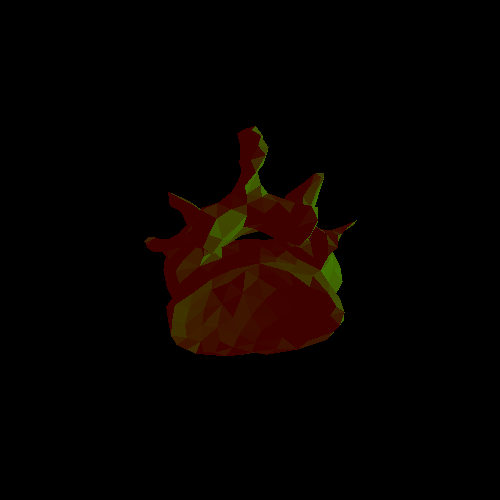

In [24]:
val priorMean = model.instance(DenseVector.zeros[Double](model.rank))
val posteriorMean = model.instance(meanSample)
render(posteriorMean)

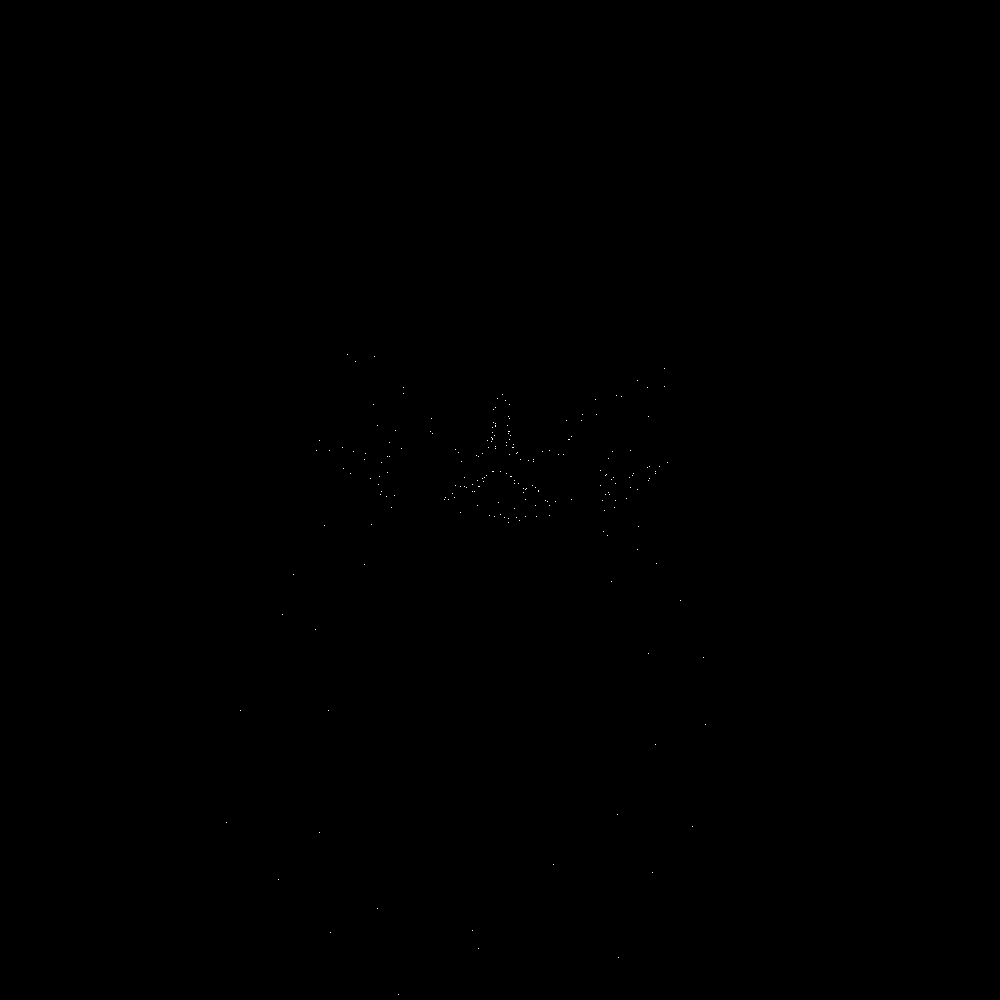

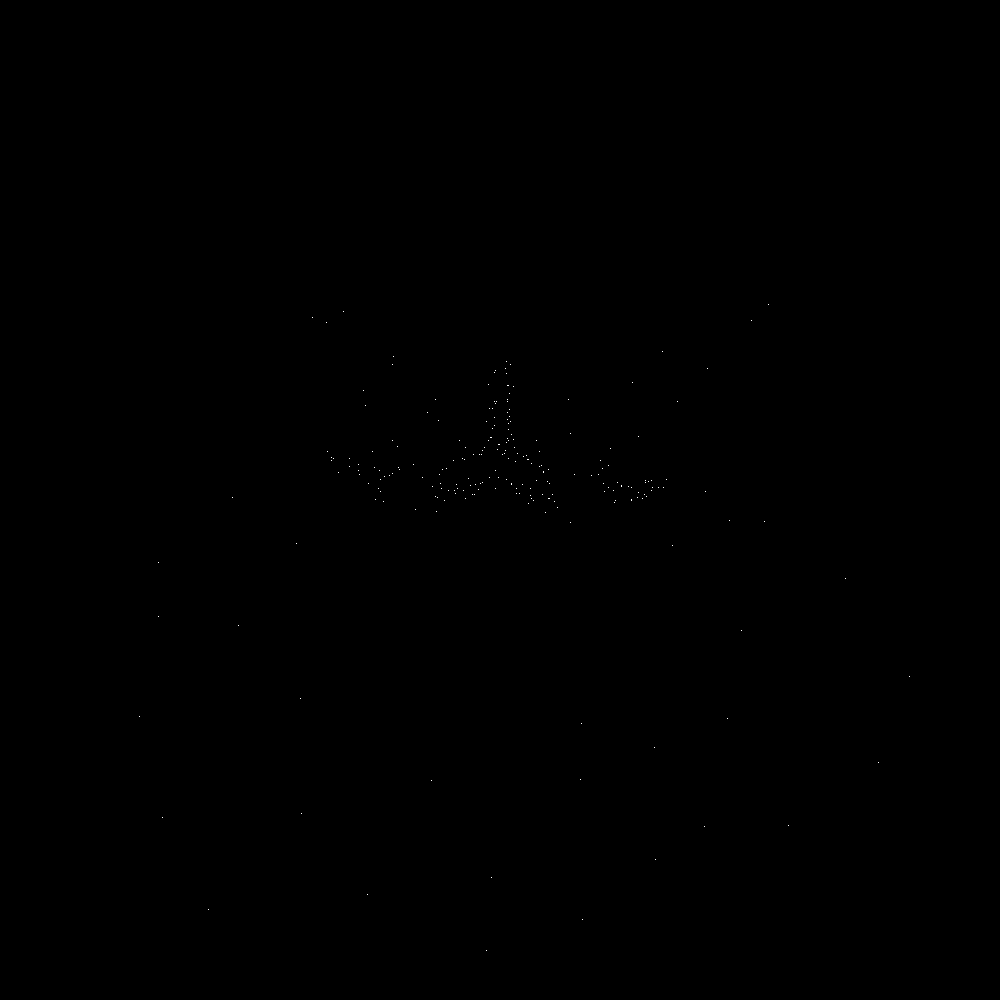

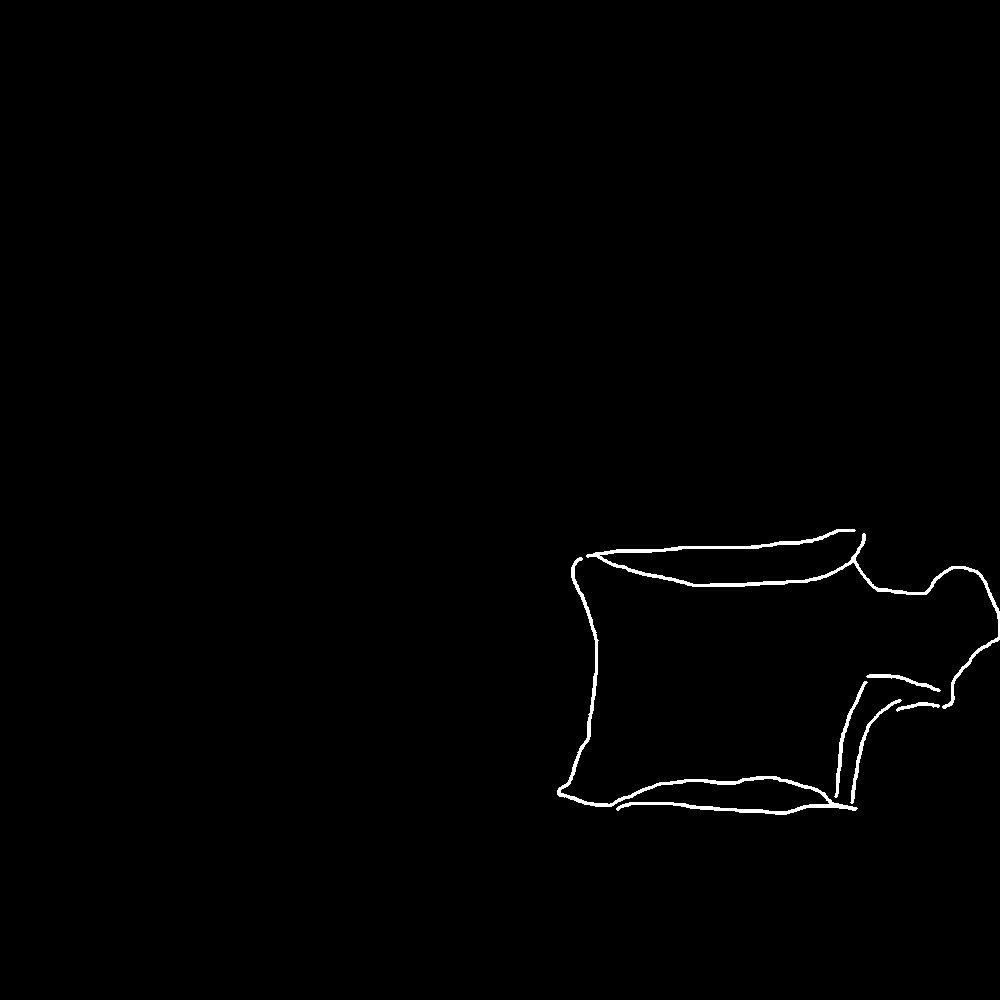

In [25]:
val reconstructedContour = ContourRenderer.projectMeshContours(posteriorMean, sensorDistance, sourceLocation)
val priorMeanContour = ContourRenderer.projectMeshContours(priorMean, sensorDistance, sourceLocation)
ContourRenderer.renderMeshContour(priorMeanContour, 1000, 1000).show()
ContourRenderer.renderMeshContour(reconstructedContour, 1000, 1000).show()
ContourRenderer.renderMeshContour(targetContour, 1000, 1000).show()

### The likelihood function, now as a distribution

In [ ]:
// import scalismo.mesh.LineMesh
// import scalismo.geometry._2D

// def loglikelihood(targetContour: LineMesh[_2D], modelCoefficients : DenseVector[Double]) : Double = 
//     val modelInstance = model.instance(modelCoefficients)
//     val sampledContour = ContourRenderer.projectMeshContours(mesh, sensorDistance, sourceLocation)
//     val sigma = 2.0
//     val likelihoods = for targetPoint <- targetContour.pointSet.points yield
//         val targetPointVec = DenseVector[Double](targetPoint.x, targetPoint.y)
//         val dist = MultivariateGaussian(targetPointVec, DenseMatrix.eye[Double](2)*sigma)
//         val closestModelPoint = sampledContour.pointSet.findClosestPoint(targetPoint).point
//         val closestModelPointVec = DenseVector(closestModelPoint.x, closestModelPoint.y)
//         dist.logPdf(closestModelPointVec)
//     likelihoods.sum
